In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from gensim.parsing.preprocessing import strip_punctuation, remove_stopwords, strip_numeric, strip_non_alphanum, strip_short

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
from wordcloud import WordCloud

In [0]:
import spacy

In [0]:
nlp = spacy.load("en_core_web_sm")

In [0]:
# Read data
df = pd.read_csv('mbti_1.csv')

In [8]:
print(df.head())

   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...


In [0]:
mbti_breakdown = Counter((df['type']))

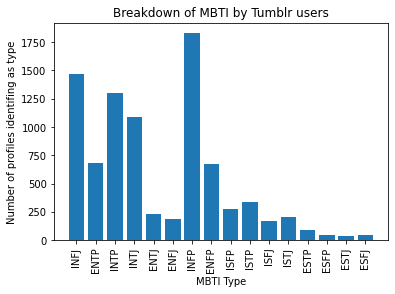

In [10]:
## Visualize ##

mbti_bd_df = pd.Series(mbti_breakdown)

chart = plt.bar(mbti_bd_df.index, mbti_bd_df)

plt.xlabel('MBTI Type')

plt.ylabel('Number of profiles identifing as type')

plt.title("Breakdown of MBTI by Tumblr users")

plt.xticks(rotation='vertical')

plt.show()

# clear imbalance in the distribution based on profiles. 'IN' types are predominate.

In [0]:
# splitting on ||| - making each individual post a column

splits_df = df['posts'].str.split('\|\|\|', expand=True)

In [0]:
df = pd.concat([df, splits_df], axis=1)

In [0]:
# turning individual strings into rows. Note that this introduces slight bias in the model, as individual sentences are catalogued instead of user's posting history.
df = pd.melt(df, id_vars='type', value_vars=df.columns[2:])

In [0]:
# Dropping rows with no text in them (this is an artifact of the split + melt)
df = df.dropna(axis=0, how='any', subset=['value'])

In [0]:
# dropping the 'variable' column (also an artifact of the split + melt)
df = df.drop(columns='variable')

In [0]:
# splitting off linear values for each class first one is 0, second one is 1
df['IE'] = np.where(df['type'].str.contains('E'), 1, 0)
df['NS'] = np.where(df['type'].str.contains('S'), 1, 0)
df['FT'] = np.where(df['type'].str.contains('T'), 1, 0)
df['PJ'] = np.where(df['type'].str.contains('J'), 1, 0)

In [0]:
# cleaning youtube/similar links, which are of little use for our current analysis
re_url =  '((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*'
df['value'] = df['value'].str.replace("'", '', regex=False)
# empty lists weren't picking up in the below filter statement, so I used punctuation to flag rows for removal
df['value'] = df['value'].str.replace(re_url, '', regex=True)

In [0]:
df['value'] = df['value'].apply(remove_stopwords)
df['value'] = df['value'].apply(strip_punctuation)
df['value'] = df['value'].apply(str.lower)
df['value'] = df['value'].apply(strip_numeric)
df['value'] = df['value'].apply(strip_non_alphanum)

In [0]:
df = df[df['value'].str.len() > 0]

In [0]:
# Takes text, returns number of nouns, pronouns, (pre)determiners, adverbs, and verbs in text
stopwords = spacy.lang.en.stop_words.STOP_WORDS
def word_filter(text):
    doc = nlp(text, disable=['ner','parser'])
    lemma = [token.lemma for token in doc]
    lem_list = [lemma.text for lemma in doc if lemma.pos_ == 'NOUN' or lemma.pos_ == 'VERB' or lemma.pos_ == 'ADJ']
    return ' '.join(lem_list)

In [0]:
df['value'] = df['value'].apply(word_filter)

In [0]:
df = df[df['value'].str.len() > 0]

In [23]:
df

,type,value,IE,NS,FT,PJ
1,ENTP,m finding lack posts alarming,1,0,1,0
2,INTP,good,0,0,1,0
3,INTJ,enjoyed gabbing arbitrary constructs created,0,0,1,1
4,ENTJ,re fired,1,0,1,1
6,INFJ,draw nails professionals nails gel mean posted...,0,0,0,1
...,...,...,...,...,...,...
735957,ENFP,change m proud things overcome life would toda...,1,0,0,0
744632,ENFP,ve relationship best friends intjs ve fallen b...,1,0,0,0
753307,ENFP,face king dreams musicbird,1,0,0,0
761982,ENFP,hard thing looking cognitive functions helpful...,1,0,0,0


In [0]:
# turning the lists into a format sklearn can read

df['value'] = df['value'].apply(''.join).str.replace(',','') #.astype('str')
df['value'] = df['value'][:][:][1:-1]

In [0]:
df = df.dropna(how='any', subset=['value'])

In [28]:
df['value'] = df['value'].apply(strip_short)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df = df.dropna(how='any', subset=['value'])

In [0]:
words = df['value'].to_string()
words = words.replace('  ', '')
total_wordcount = Counter(words.split(' '))

In [32]:
# The 50 most common words
for word, count in total_wordcount.most_common(50):
  print(word, " - ", count)

think  -  24591
people  -  23957
know  -  18878
time  -  14231
feel  -  11983
love  -  10712
good  -  10491
want  -  10077
things  -  9546
type  -  9458
lot  -  9224
way  -  8205
like  -  7839
thing  -  7710
life  -  7478
friends  -  6557
going  -  6496
person  -  6075
need  -  6042
got  -  5949
thread  -  5939
intj  -  5924
said  -  5591
friend  -  5522
thought  -  5470
work  -  5341
years  -  5169
read  -  5124
try  -  4880
mean  -  4641
post  -  4358
little  -  4325
look  -  4291
best  -  4200
sure  -  4183
bit  -  4052
makes  -  3981
point  -  3830
mind  -  3734
tell  -  3679
trying  -  3679
different  -  3665
come  -  3664
day  -  3610
use  -  3593
guys  -  3590
bad  -  3587
types  -  3578
talk  -  3550
great  -  3542


In [0]:
stopword_list = [word for word, count in total_wordcount.most_common(30)]

In [0]:
# building a function which takes in the dataframe and builds a wordcloud

def wordcloud_analysis(mbti, order=0):
  filtered = df[df[mbti] == order]
  mbti_words = filtered['value'].to_string()
  wordcloud = WordCloud(relative_scaling=0, stopwords=stopword_list).generate(mbti_words)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

Most common words for each personality type (there's a lot of overlap)

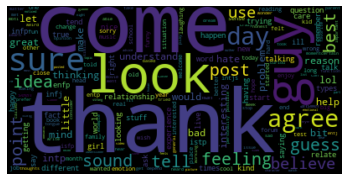

In [36]:
# Introverts
wordcloud_analysis('IE', 0)

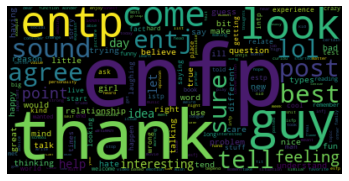

In [37]:
# Extroverts
wordcloud_analysis('IE', 1)

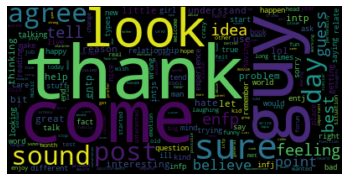

In [38]:
# Intuitive
wordcloud_analysis('NS', 0)

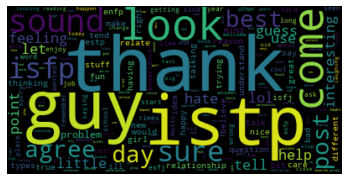

In [39]:
# Sensing
wordcloud_analysis('NS', 1)

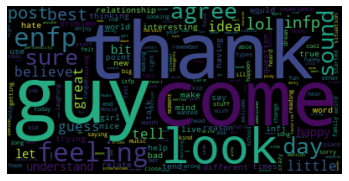

In [40]:
# Feeling
wordcloud_analysis('FT', 0)

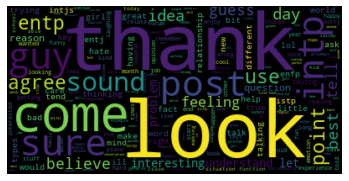

In [41]:
# Thinking
wordcloud_analysis('FT', 1)

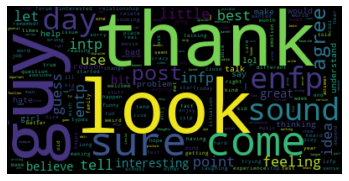

In [42]:
# Perceiving
wordcloud_analysis('PJ', 0)

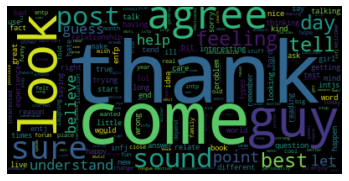

In [43]:
# Judging
wordcloud_analysis('PJ', 1)

In [0]:
vectorizer = TfidfVectorizer(stop_words='english',strip_accents='ascii', min_df=20, max_features=600, use_idf='True')

In [0]:
tfidf_text = vectorizer.fit_transform(df['value'])

In [0]:
tfidf_df = pd.DataFrame(tfidf_text.toarray(), columns=vectorizer.get_feature_names(), dtype='int', copy=True)

In [0]:
# Analysis

df = pd.concat((df[['IE','NS','FT','PJ']], tfidf_df), axis=1)

In [0]:
df = df.dropna(how='any', subset=['value'])

In [0]:
# determines the top word differences (and MBTI differences) between each of the 4 MBTI classes
def top_diff(mbti):
  vals = df.groupby(mbti).mean()
  difference = vals.iloc[0] - vals.iloc[1]
  print(difference.abs().sort_values(kind='quicksort', ascending=False).head(n=50))

In [50]:
# Differences b/t introverts/extroverts
top_diff('IE')

PJ             0.188367
FT             0.084589
NS             0.037663
think          0.000604
want           0.000282
know           0.000251
time           0.000201
intj           0.000176
feel           0.000152
mean           0.000149
strong         0.000137
true           0.000137
nice           0.000136
lol            0.000135
sent           0.000130
great          0.000128
person         0.000127
called         0.000126
laughing       0.000125
thought        0.000123
wait           0.000121
words          0.000118
isfp           0.000118
read           0.000115
idea           0.000114
say            0.000114
looking        0.000112
people         0.000112
trying         0.000111
going          0.000109
confused       0.000108
got            0.000108
says           0.000106
good           0.000105
reading        0.000105
interesting    0.000103
special        0.000102
female         0.000098
music          0.000095
social         0.000094
man            0.000094
wish           0

In [51]:
# Differences between intuitives/sensings
top_diff('NS')

FT             0.122665
IE             0.057282
PJ             0.016799
know           0.000396
laughing       0.000324
think          0.000319
intj           0.000267
come           0.000259
thank          0.000249
science        0.000237
good           0.000235
thanks         0.000220
lol            0.000216
time           0.000208
watch          0.000205
look           0.000196
guess          0.000192
new            0.000191
type           0.000187
wink           0.000178
agree          0.000167
going          0.000166
saw            0.000164
interesting    0.000161
thought        0.000149
funny          0.000148
mind           0.000147
explain        0.000145
matter         0.000145
kind           0.000140
years          0.000136
choose         0.000133
love           0.000130
welcome        0.000130
isfp           0.000128
personal       0.000128
hear           0.000128
got            0.000128
entp           0.000127
head           0.000126
tongue         0.000125
sure           0

In [52]:
# Difference between feeling/thinking
top_diff('FT')

IE             0.060790
NS             0.057961
PJ             0.008873
welcome        0.000288
think          0.000276
know           0.000271
thanks         0.000192
people         0.000165
love           0.000157
man            0.000147
help           0.000141
watching       0.000139
intj           0.000139
feel           0.000137
thread         0.000134
like           0.000134
want           0.000126
thank          0.000120
entj           0.000117
friend         0.000110
use            0.000109
interesting    0.000107
crazy          0.000106
ask            0.000105
lets           0.000103
stuff          0.000103
says           0.000102
cool           0.000101
true           0.000094
feeling        0.000094
tongue         0.000090
listening      0.000090
read           0.000089
laughing       0.000085
great          0.000084
sent           0.000083
way            0.000083
random         0.000082
big            0.000080
second         0.000076
problem        0.000076
perfect        0

In [53]:
# Difference between perceiving and judging
top_diff('PJ')

IE            0.140412
FT            0.009203
NS            0.008233
tongue        0.000305
thread        0.000221
time          0.000221
sounds        0.000187
cool          0.000168
way           0.000149
want          0.000138
sent          0.000133
things        0.000133
world         0.000126
welcome       0.000125
thank         0.000117
understand    0.000115
list          0.000114
going         0.000112
live          0.000108
laughing      0.000106
sleep         0.000105
love          0.000102
night         0.000100
agree         0.000100
sure          0.000099
awesome       0.000097
mean          0.000095
friends       0.000095
right         0.000089
wrong         0.000088
new           0.000086
great         0.000086
nice          0.000086
hope          0.000086
wait          0.000085
heres         0.000085
post          0.000083
lost          0.000082
true          0.000082
thing         0.000081
video         0.000080
entp          0.000080
little        0.000080
story      

While it's possible that MBTI still has an impact on personality, the impact on vocabulary isn't significant enough to warrant further statistical modeling. An applied (Sparse Array) Principle Component Analysis found weights between variables near non-existant.

Small differences between vocabulary of personality types can be noted above, particularly in regard to words like 'tounge' 'think', 'know', 'laughing', and 'welcome'.

While these results are less insightful than I would have liked, they neverless cast doubt upon the impact of Jungian architypes on word choices for communicating online

Regardless, this has been an interesting exercise in text processing for natural language.